In [1]:
# %%capture
# !pip install kornia
# !pip install kornia-rs
# !pip install kornia_moons
# !pip install opencv-python --upgrade

In [2]:
import cv2
import kornia as K
import kornia.augmentation as KA
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.feature import *
from kornia_moons.viz import *
import timeit
import time
from torch import nn

In [3]:
POINTS_LIMIT = 90

def criar_mascara(size_batch,dimensao_janela, tamanho_borda):
    
    mascara = torch.zeros((size_batch,1, dimensao_janela, dimensao_janela), dtype=torch.uint8)
    mascara[..., tamanho_borda:-tamanho_borda, tamanho_borda:-tamanho_borda] = 1

    return mascara.to(torch.float32)

def predict_all_descritor(input_data,mask):
    features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= model(input_data*mask)    
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_size = features_key.shape[0]
    batch_points = torch.zeros((batch_size,POINTS_LIMIT, 2))
    for i in range(batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]
    
        try:
            batch_points[i,:max_coords_temp2.shape[0]] = max_coords_temp2
        except:
            print(max_coords_temp2.shape,batch_points.shape)
            print('nao tem pontos suficientes')
    return features_key,features_ori,batch_points

def create_circular_mask(h, w, center=None, radius=None):
    """
    Create a circular mask of shape (h, w).
    :param h: height of the mask
    :param w: width of the mask
    :param center: (x, y) tuple of the center
    :param radius: radius of the circle
    :return: (h, w) binary mask
    """

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask
  
def get_bounding_boxs(batch,points,size=14):
  '''
  Recebe um lote de imagens e um conjunto de pontos e retorna uma lista de bounding boxs para cada imagem
  '''
  mask = create_circular_mask(size,size)
  half1 = size // 2
  half2 = size - half1
  
  num_batch = batch.shape[0]
  num_layer = batch.shape[1]
  num_poits = points.shape[1]
  bounding_boxs = torch.zeros((num_batch,num_poits,num_layer,size,size),dtype=torch.float32)
  
  for image_idx,image in enumerate(batch):
    for point_idx,point in enumerate(points[image_idx]):
      y, x = map(int, point)
      try:
        bounding_boxs[image_idx,point_idx]=image[:,x - half1:x + half2, y - half1:y + half2]
      except:
        print("erro")
        print(x,y,half1,half2)
  return bounding_boxs*mask

# Cria uma camada de pooling global average
global_avg_pool = nn.AdaptiveAvgPool2d(1)
global_max_pool = nn.AdaptiveMaxPool2d(1)
# Aplica o pooling global average no tensor de entrada
# output = global_avg_pool(x)


def bidirectional_match(feat1, feat2):
    # Converter para tipo de ponto flutuante
    feat1 = feat1.float()
    feat2 = feat2.float()

    # Cálculo das diferenças entre pares de elementos
    diff = feat1.unsqueeze(1) - feat2.unsqueeze(0)

    # Cálculo da distância Euclidiana
    dist_matrix = torch.norm(diff, p=2, dim=2)

    # Encontrar os índices dos elementos mais próximos em ambas as direções
    min_indices_feat1_to_feat2 = torch.argmin(dist_matrix, dim=1)
    min_indices_feat2_to_feat1 = torch.argmin(dist_matrix, dim=0)

    # Consolidar as correspondências únicas
    matches = []
    for i, match_index in enumerate(min_indices_feat1_to_feat2):
        if min_indices_feat2_to_feat1[match_index] == i:
            matches.append((i, match_index.item()))

    return matches

In [4]:
import best.singular_point as sp


import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = './data/models/sp_52.pth'
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_siamese)

Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model loaded from ./data/models/sp_52.pth


In [9]:
temp = torch.rand(1,1,256,256)
model(temp)

AssertionError: Error! The size of the tensor torch.Size([1, 1, 256, 256]) does not match the size of the field type 3.

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import torchvision
from torchvision.transforms import transforms, InterpolationMode

def image_to_batch_tensor(image_path, size):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    return transform(Image.open(image_path)).unsqueeze(0)

transform = transforms.Compose([
    transforms.Resize((sp.args.img_size, sp.args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                        shuffle=False, num_workers=2)

first_batch = next(iter(trainloader))[0].to(sp.device)

In [ ]:

RADIUS = 10
INDEX1 = 0
INDEX2 = 0

import torch
import kornia as K

def laf_from_opencv_kpts(xy: torch.Tensor, device: torch.device=torch.device('cpu')) -> torch.Tensor:
    B, N, _ = xy.shape
    scales = torch.zeros(B, N, 1, 1, device=device, dtype=torch.float)
    angles = torch.zeros(B, N, 1, device=device, dtype=torch.float)
    laf = K.feature.laf_from_center_scale_ori(xy, scales, angles).reshape(B, -1, 2, 3)
    return laf


simple_transformations = KA.AugmentationSequential(
    KA.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input']  # Especificando as chaves de dados
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 90, 2, 3]) torch.Size([1, 90, 2, 3]) (62, 2) (120, 120, 3) (120, 120, 3) (62, 1)
37 inliers found


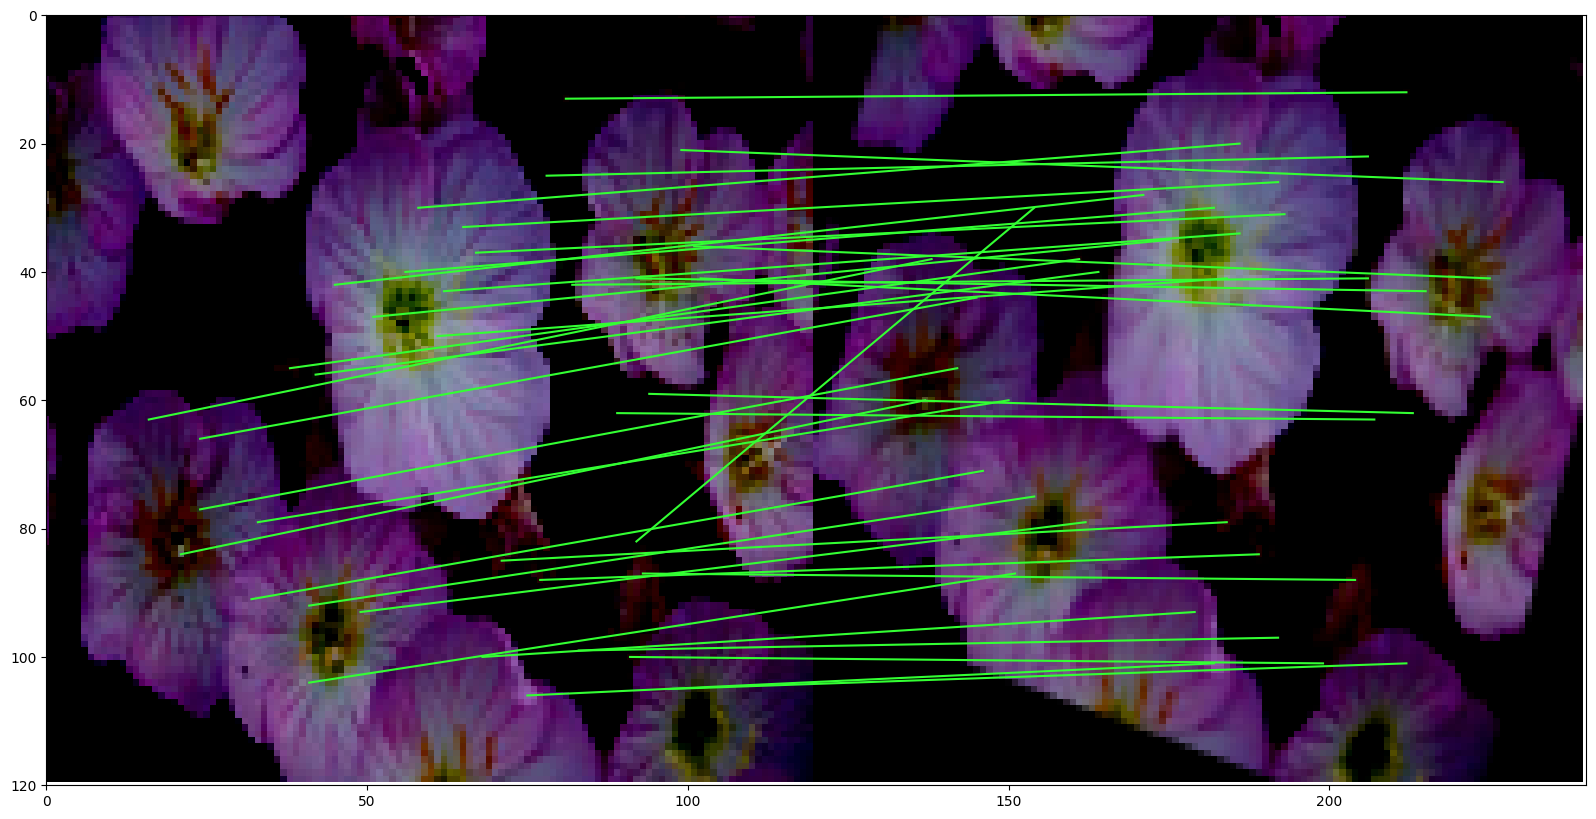

In [ ]:
def detect_and_display_correspondences(batch_image, batch_image_trans):
    with torch.no_grad():
        mask = criar_mascara(first_batch.shape[0], first_batch.shape[-1], sp.args.border_size).to(sp.device)
        features_key, features_ori, batch_points = predict_all_descritor(batch_image, mask)
        if batch_image_trans is None:
          batch_image_trans, mask_trans = simple_transformations(first_batch, mask)  # transformar orientacoes e pontos

        features_key_t2, features_ori_t2, batch_points_t2 = predict_all_descritor(batch_image_trans, mask_trans)
        
        sub_key_1 = get_bounding_boxs(features_key.cpu(), batch_points, size=RADIUS*2)
        sub_key_2 = get_bounding_boxs(features_key_t2.cpu(), batch_points_t2, size=RADIUS*2)
        

    desc_1 = torch.cat([global_avg_pool(sub_key_1[INDEX1]).squeeze(), global_max_pool(sub_key_1[INDEX1]).squeeze()], dim=1)
    desc_2 = torch.cat([global_avg_pool(sub_key_2[INDEX2]).squeeze(), global_max_pool(sub_key_2[INDEX2]).squeeze()], dim=1)
    
    lafs1 = laf_from_opencv_kpts(batch_points)
    lafs2 = laf_from_opencv_kpts(batch_points_t2)

    match = np.array(bidirectional_match(desc_1, desc_2))
    src_pts = np.float32([batch_points.numpy()[0, m[0]] for m in match])
    dst_pts = np.float32([batch_points_t2.numpy()[0, m[1]] for m in match])

    F, inliers_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.25, 0.999, 1000)
    print(lafs1.shape,lafs2.shape,match.shape,first_batch[0].cpu().numpy().transpose(1, 2, 0).shape,batch_image_trans[0].cpu().numpy().transpose(1, 2, 0).shape,inliers_mask.shape)
    # Drawing matches using kornia_moons
    draw_LAF_matches(
        lafs1,
        lafs2,
        match,
        first_batch[0].cpu().numpy().transpose(1, 2, 0),
        batch_image_trans[0].cpu().numpy().transpose(1, 2, 0),
        inliers_mask,
        draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": None, "vertical": False},
    )
    print(f"{inliers_mask.sum()} inliers found")
    
    
detect_and_display_correspondences(first_batch, None)

torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


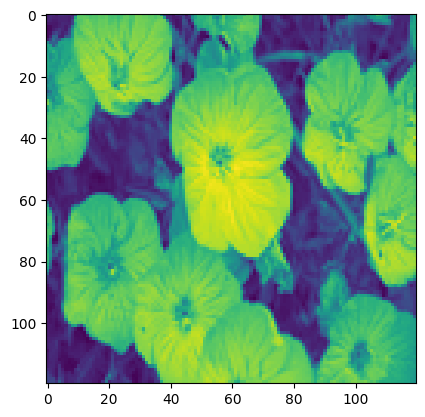

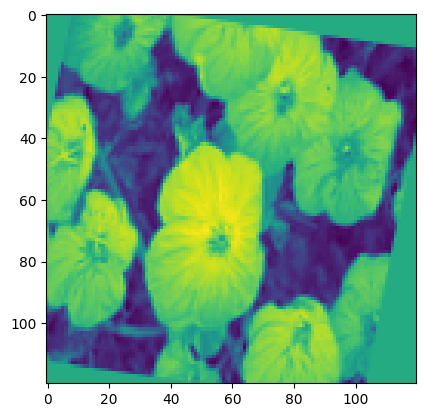

torch.Size([93, 128]) torch.Size([88, 128]) torch.Size([0, 1]) torch.Size([0, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


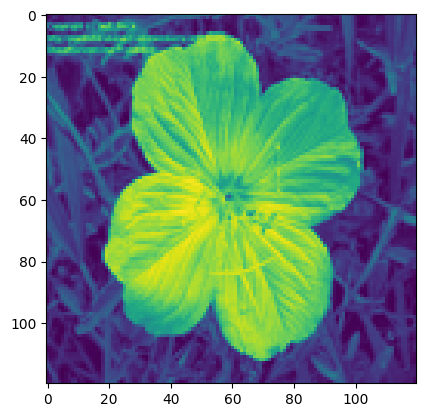

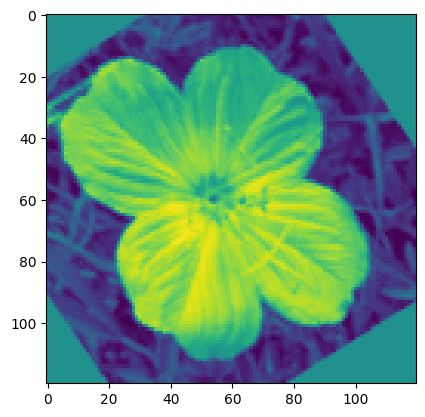

torch.Size([109, 128]) torch.Size([95, 128]) torch.Size([24, 1]) torch.Size([24, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


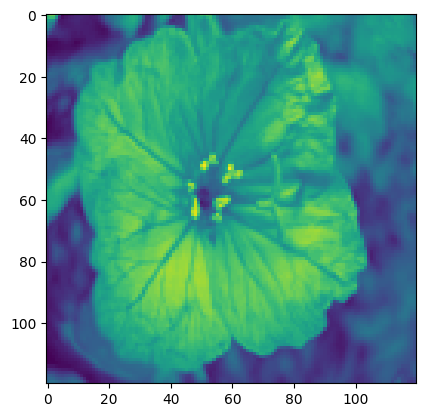

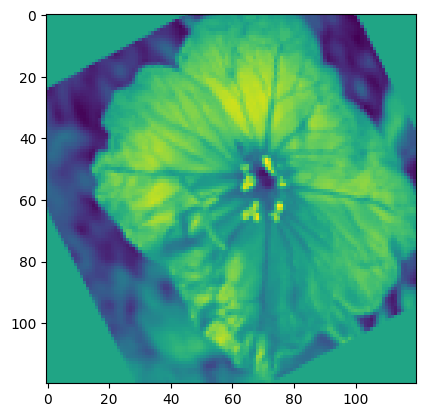

torch.Size([103, 128]) torch.Size([96, 128]) torch.Size([2, 1]) torch.Size([2, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


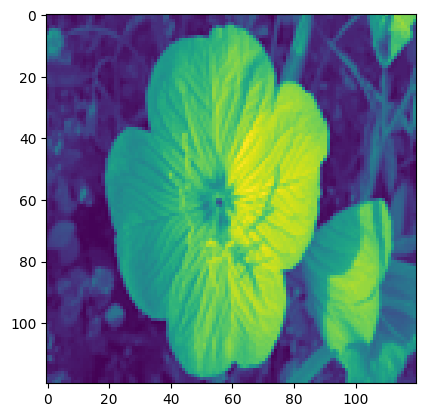

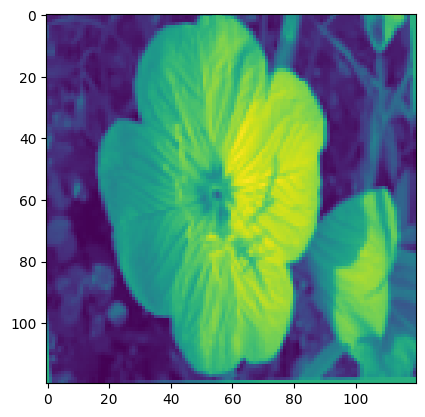

torch.Size([83, 128]) torch.Size([81, 128]) torch.Size([55, 1]) torch.Size([55, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


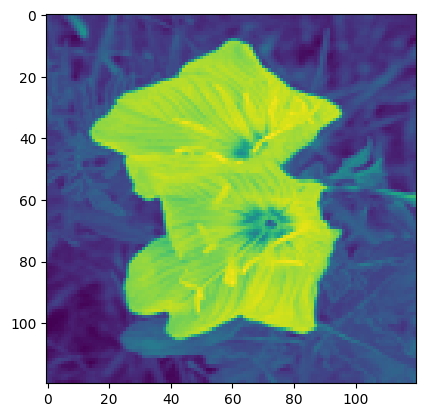

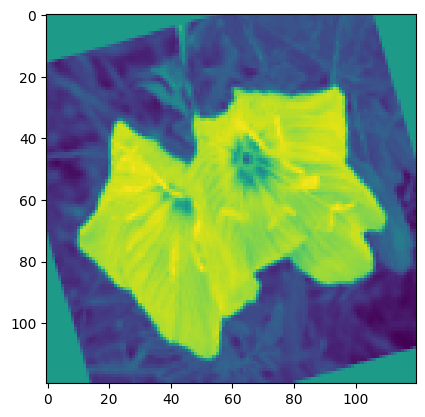

torch.Size([82, 128]) torch.Size([83, 128]) torch.Size([0, 1]) torch.Size([0, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


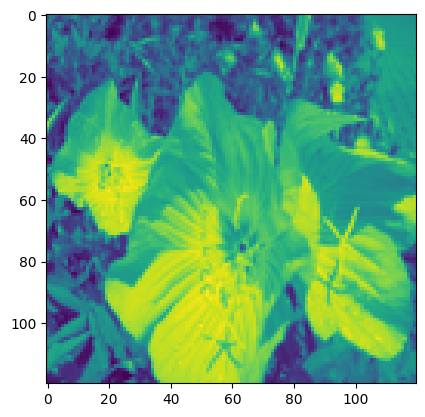

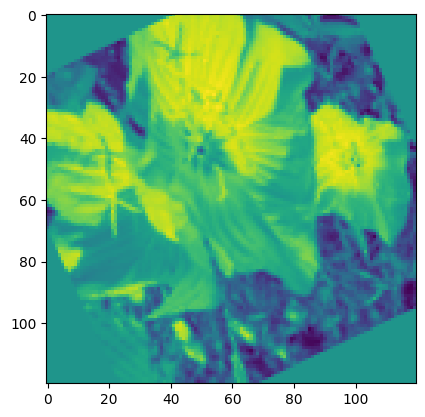

torch.Size([99, 128]) torch.Size([93, 128]) torch.Size([1, 1]) torch.Size([1, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


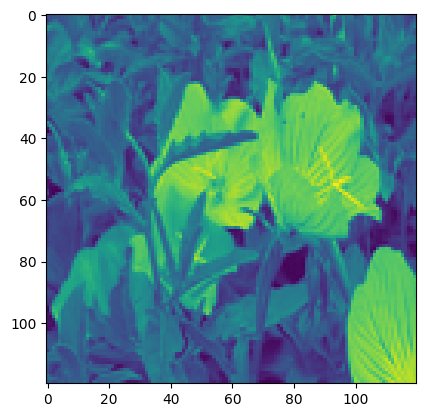

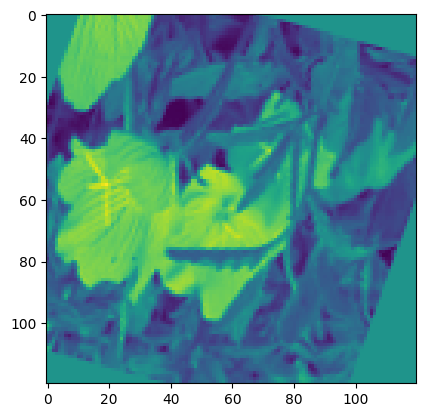

torch.Size([95, 128]) torch.Size([99, 128]) torch.Size([0, 1]) torch.Size([0, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


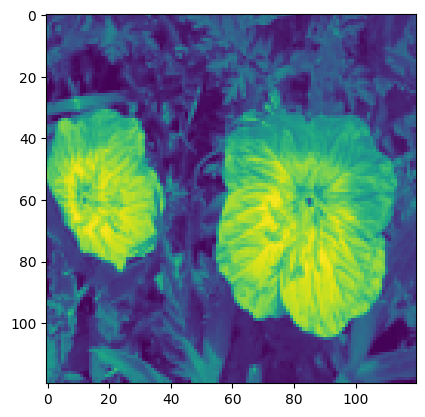

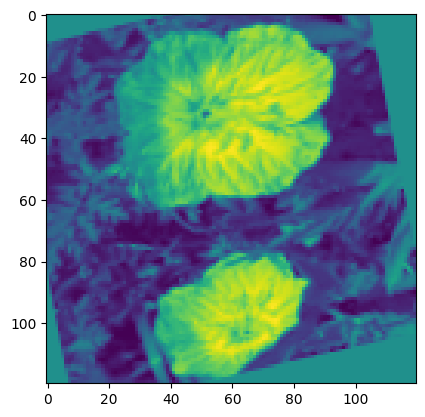

torch.Size([107, 128]) torch.Size([97, 128]) torch.Size([1, 1]) torch.Size([1, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


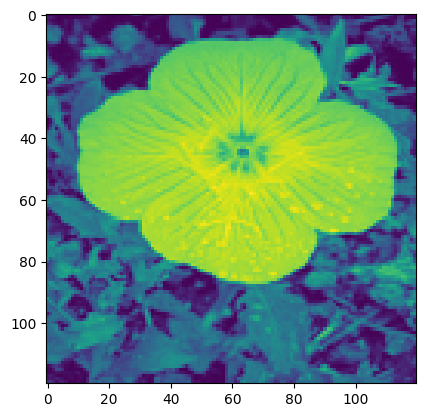

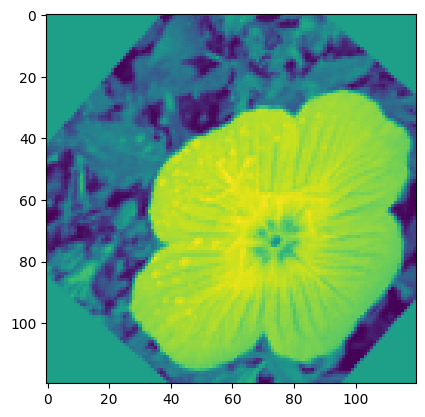

torch.Size([93, 128]) torch.Size([83, 128]) torch.Size([2, 1]) torch.Size([2, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


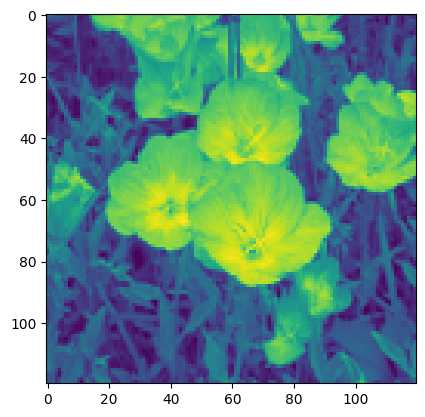

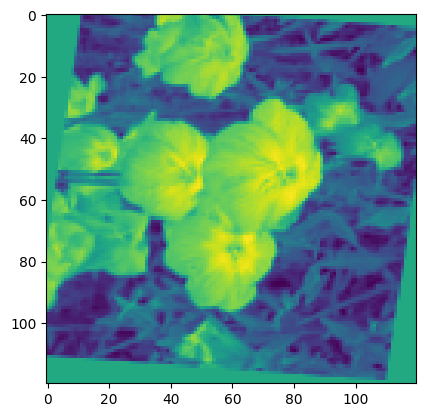

torch.Size([90, 128]) torch.Size([88, 128]) torch.Size([6, 1]) torch.Size([6, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


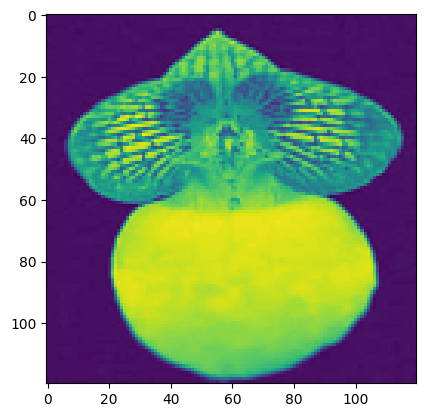

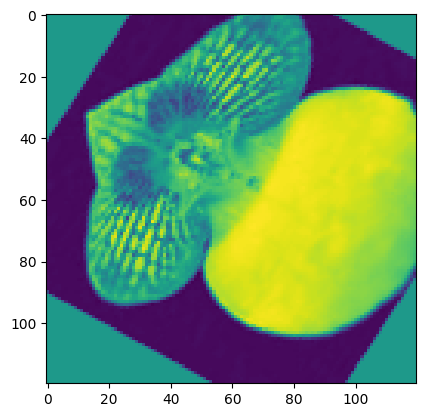

torch.Size([71, 128]) torch.Size([79, 128]) torch.Size([9, 1]) torch.Size([9, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


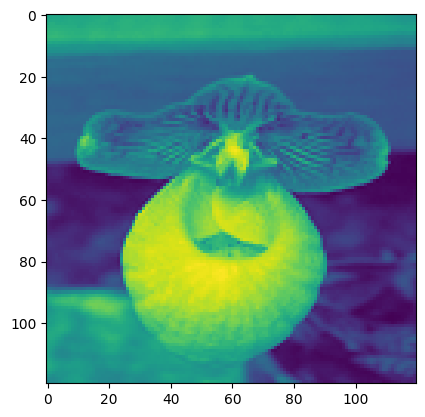

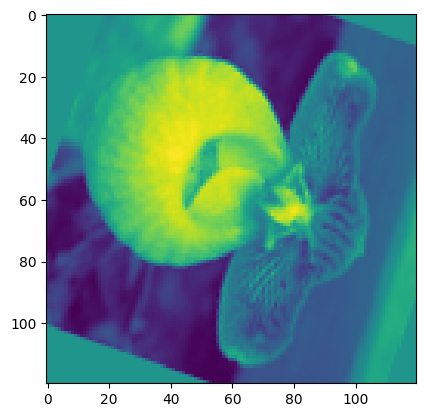

torch.Size([75, 128]) torch.Size([78, 128]) torch.Size([1, 1]) torch.Size([1, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


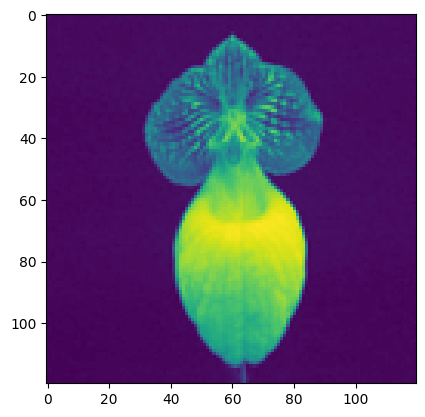

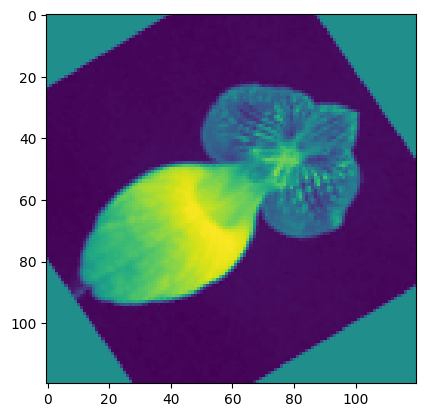

torch.Size([48, 128]) torch.Size([57, 128]) torch.Size([4, 1]) torch.Size([4, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


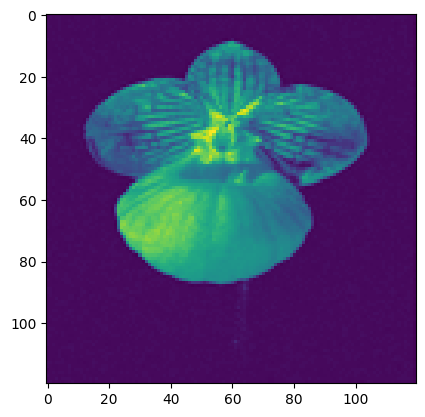

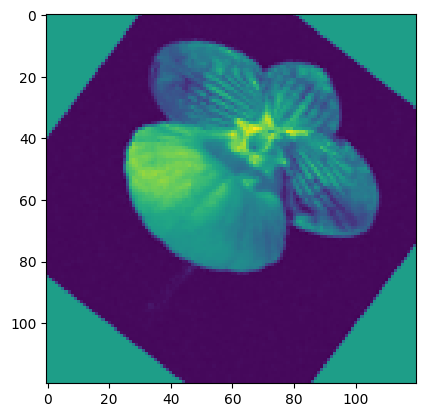

torch.Size([61, 128]) torch.Size([73, 128]) torch.Size([20, 1]) torch.Size([20, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


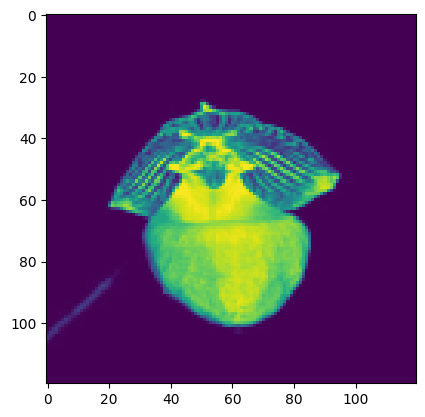

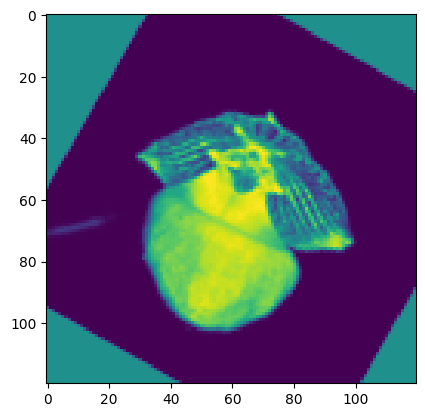

torch.Size([43, 128]) torch.Size([57, 128]) torch.Size([15, 1]) torch.Size([15, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


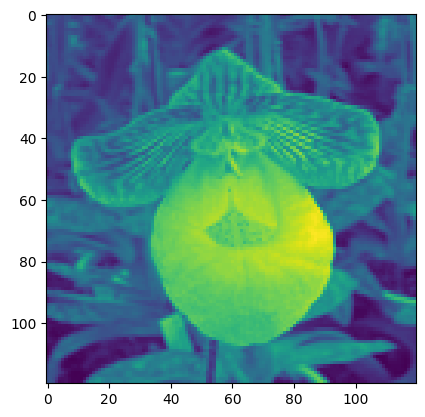

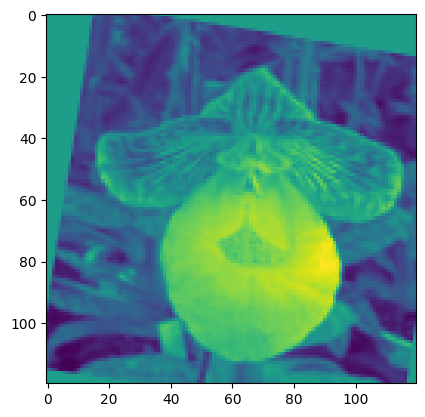

torch.Size([92, 128]) torch.Size([87, 128]) torch.Size([42, 1]) torch.Size([42, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


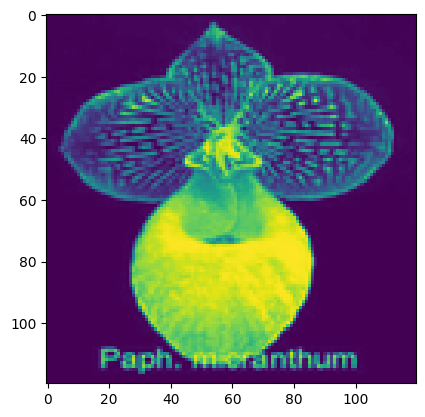

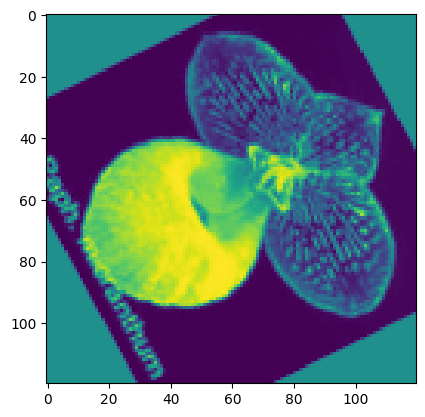

torch.Size([72, 128]) torch.Size([79, 128]) torch.Size([3, 1]) torch.Size([3, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


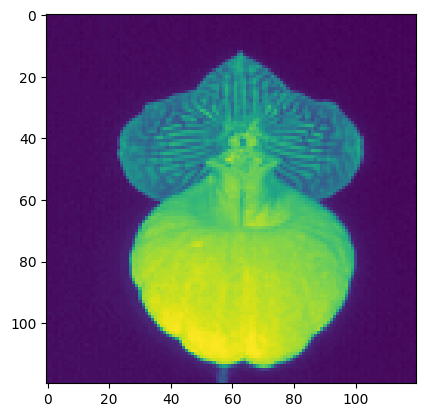

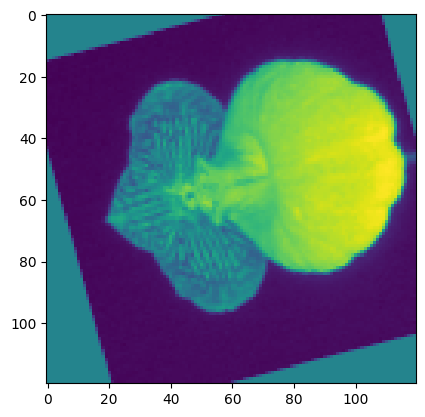

torch.Size([59, 128]) torch.Size([60, 128]) torch.Size([1, 1]) torch.Size([1, 2])
torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


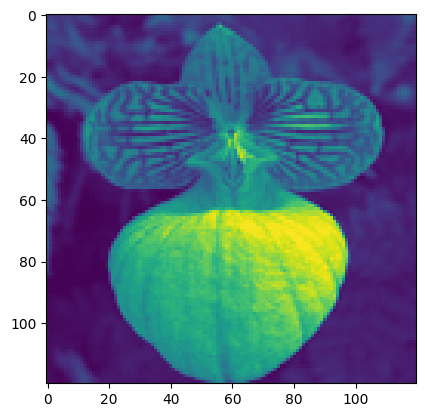

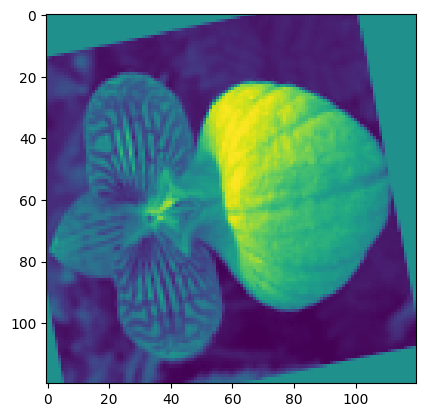

KeyboardInterrupt: 

In [ ]:
import torch
import kornia.feature as KF
import torchvision
from torchvision.transforms import transforms, InterpolationMode
import kornia.augmentation as KA

transform2 = transforms.Compose([
    transforms.Resize((120,120), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                        shuffle=False, num_workers=2)



def detect_and_match(first_batch,second_batch,keynet_hardnet,matcher):
    kp1, _, desc1 = keynet_hardnet(first_batch)
    kp2, _, desc2 = keynet_hardnet(second_batch)

    # Remove a dimensão extra dos descritores
    desc1 = desc1[0]
    desc2 = desc2[0]
    # Realiza a correspondência dos descritores
    dist,matches = matcher(desc1, desc2)
    print(desc1.shape,desc2.shape,dist.shape,matches.shape)
    return kp1,kp2,matches
    
keynet_hardnet = KF.KeyNetHardNet()
matcher = KF.DescriptorMatcher('snn', 0.5)

for data in trainloader:
    first_batch,_ = data
    random = KA.RandomAffine(degrees=180, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5, p=0.8)
    second_batch = random(first_batch)
    
    
    print(first_batch.shape,second_batch.shape)
    plt.imshow(first_batch[0].permute(1,2,0))
    plt.show()
    plt.imshow(second_batch[0].permute(1,2,0))
    plt.show()
    kp1,kp2,matches =detect_and_match(first_batch,second_batch,keynet_hardnet,matcher)


torch.Size([1, 1, 120, 120]) torch.Size([1, 1, 120, 120])


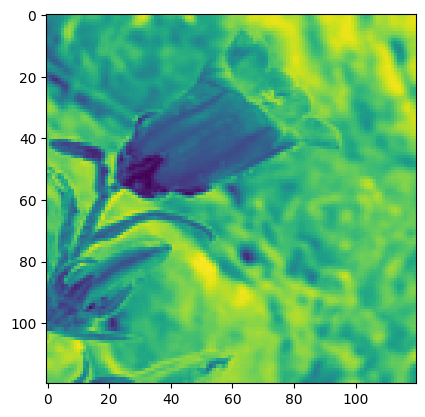

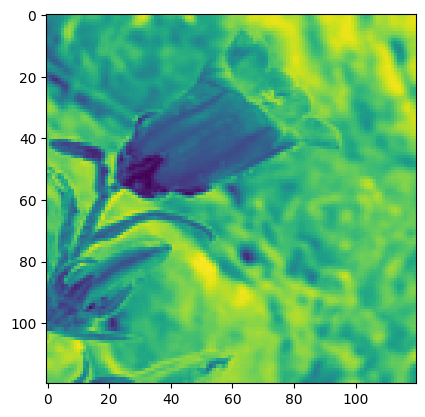

In [ ]:

print(first_batch.shape,second_batch.shape)
plt.imshow(first_batch[0].permute(1,2,0))
plt.show()
plt.imshow(second_batch[0].permute(1,2,0))
plt.show()

In [ ]:
import kornia.augmentation as KA
import kornia.geometry.conversions as KGC
# Definir as transformações individuais
random_affine = KA.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10, p=0.8)
color_jitter = KA.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
random_horizontal_flip = KA.RandomHorizontalFlip(p=0.5)
random_vertical_flip = KA.RandomVerticalFlip(p=0.5)

# Acessar os parâmetros das transformações individuais
affine_params = random_affine.forward_parameters((120,120))
jitter_params = color_jitter.parameters
print(affine_params.keys())
# Imprimir os parâmetros
print("RandomAffine Parameters:", affine_params['center'].shape,affine_params['scale'].shape,affine_params['angle'].shape,affine_params['batch_prob'].shape)
print("ColorJitter Parameters:", jitter_params)


dict_keys(['translations', 'center', 'scale', 'angle', 'shear_x', 'shear_y', 'batch_prob', 'forward_input_shape'])
RandomAffine Parameters: torch.Size([97, 2]) torch.Size([97, 2]) torch.Size([97]) torch.Size([120])


TypeError: convert_affinematrix_to_homography() takes 1 positional argument but 4 were given